## Santander Customer Transactions predictions

#BigDataSets##HighDimensionality#DataBalancing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random
import scipy as sp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

import seaborn as sns; sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Data Exploration

the submission contains the forecasted prices, then I merge the submission and the Test set

In [4]:
train = pd.read_csv('train.csv')
ss = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
#test = test.merge(ss, left_on = 'ID_code', right_on = 'ID_code', how = 'inner')

In [5]:
train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

#### Measuring null data

Droping those that have high number of empty rows

In [6]:
def nullcalc(df,variable):
    nulls = len(df[df[variable].isna()])
    rows = len(df)
    value = round(len(df[df[variable].isna()])/len(train)*100,2)
    string =  'The column ' + variable + ' has ' + str(value) + '% of nulls'
    return string,value

In [7]:
for variable in train.columns:
    if nullcalc(train,variable)[1] > 0 :
        print(nullcalc(train,variable)[0])

seems that data is 100% complete so no nulls

<b> More Exploration

Target

In [8]:
df = train.pivot_table(index = 'target', aggfunc = 'count')[['ID_code']].reset_index()
df['total'] = df.ID_code.sum()
df = df.assign(percent = df.ID_code/df.total)

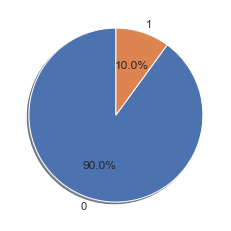

In [9]:
fig1, ax1 = plt.subplots()
ax1.pie(df.percent, labels = df.target , autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

Target will need balance

<b> variable by variable

In [10]:
def plotviolins(data,ini):
    fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(27,10))
    varsuse = 5
    rows = [0,0,0,0,0,1,1,1,1,1]
    cols =[0,1,2,3,4,0,1,2,3,4]
    ini = ini

    for row,col in zip(rows,cols):

        end = ini + varsuse
        columns = list(data.columns[ini:end])
        df = data[columns + ['target'] ].melt(id_vars=['target'], value_vars = columns, var_name='Var', value_name='Value')
        sns.violinplot(ax = axs[row,col], data=df, x="Var", y="Value", hue="target",split=True, inner="quart", linewidth=1,scale="count")

        ini = end

    return plt.show()

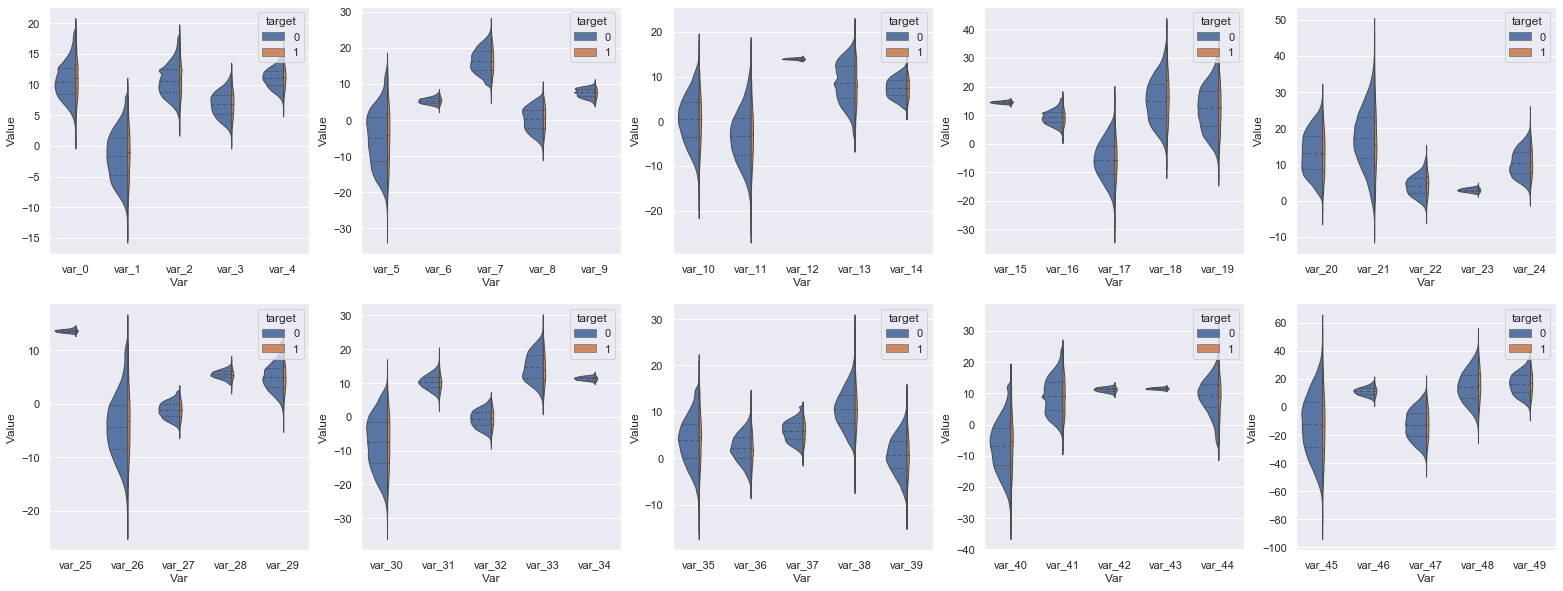

In [13]:
plotviolins(train,ini = 2)

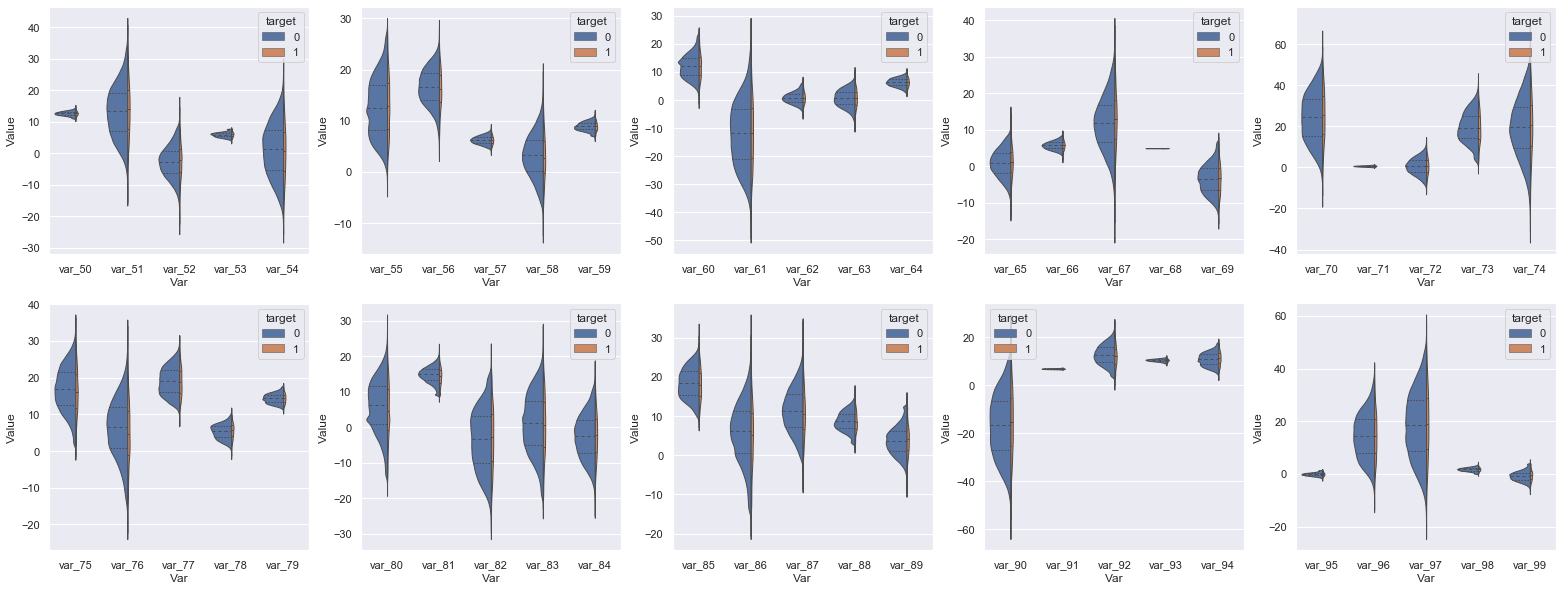

In [14]:
plotviolins(train,ini = 52)

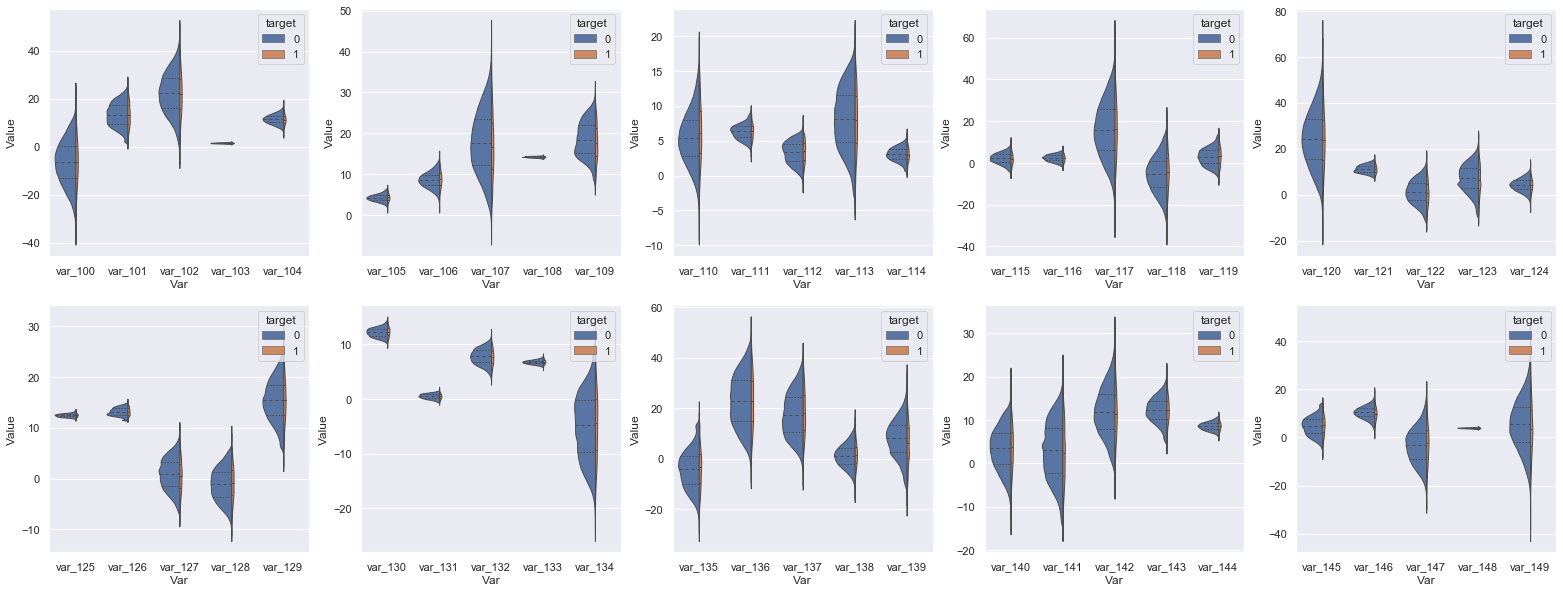

In [15]:
plotviolins(train,ini = 102)

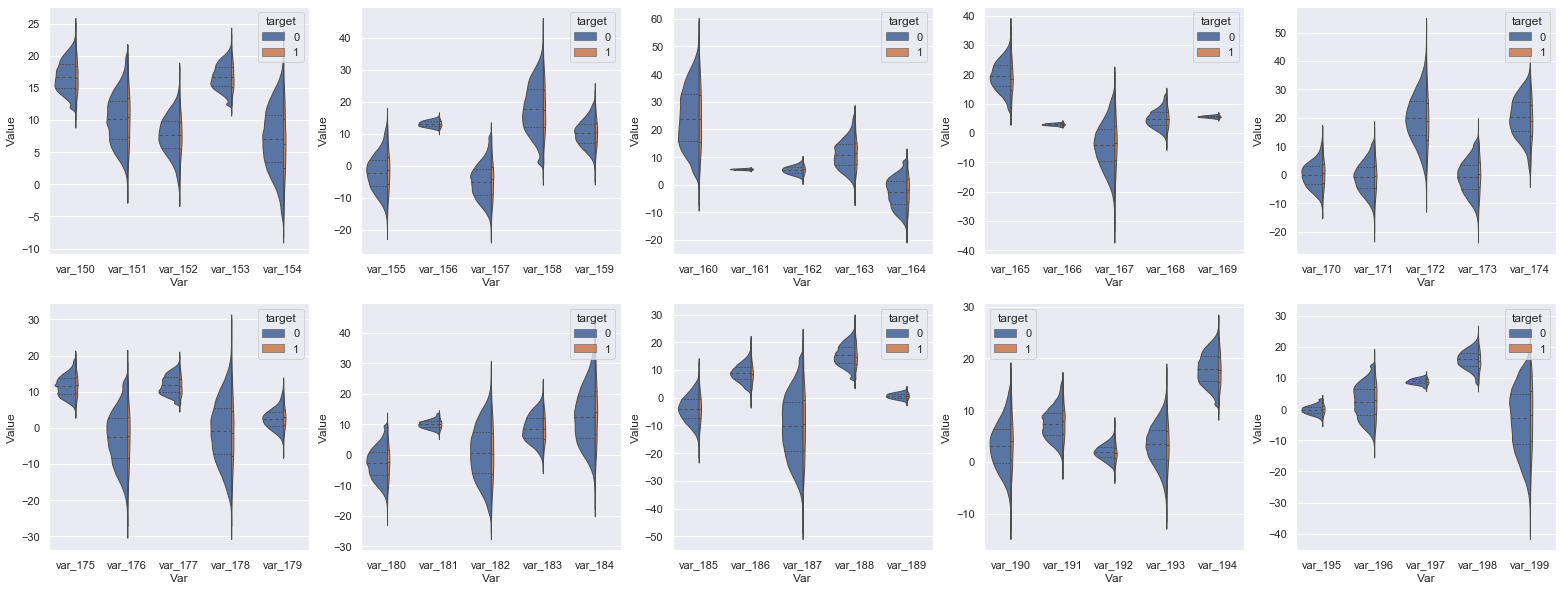

In [16]:
plotviolins(train,ini = 152)

interesting the distribution of all the variables

### Feature analysis

In [6]:
correlations = train.iloc[:,2::].corr()

finding high correlations

In [7]:
correlations

var_0     var_1     var_2     var_3     var_4     var_5     var_6  \
var_0    1.000000 -0.000544  0.006573  0.003801  0.001326  0.003046  0.006983   
var_1   -0.000544  1.000000  0.003980  0.000010  0.000303 -0.000902  0.003258   
var_2    0.006573  0.003980  1.000000  0.001001  0.000723  0.001569  0.000883   
var_3    0.003801  0.000010  0.001001  1.000000 -0.000322  0.003253 -0.000774   
var_4    0.001326  0.000303  0.000723 -0.000322  1.000000 -0.001368  0.000049   
...           ...       ...       ...       ...       ...       ...       ...   
var_195  0.002073 -0.000785 -0.001070  0.001206  0.003706 -0.001274  0.001244   
var_196  0.004386 -0.000377  0.003952 -0.002800  0.000513  0.002880  0.005378   
var_197 -0.000753 -0.004157  0.001078  0.001164 -0.000046 -0.000535 -0.003565   
var_198 -0.005776 -0.004861 -0.000877 -0.001651 -0.001821 -0.000953 -0.003025   
var_199  0.003850  0.002287  0.003855  0.000506 -0.000786  0.002767  0.006096   

            var_7     var_8     var_9  ...   var_190   var_191   var_192  \
var_0    0.002429  0.004962 -0.002613  ...  0.002752  0.000206 -0.005373   
var_1    0.001511  0.004098 -0.000832  ...  0.006627  0.003621 -0.002604   
var_2   -0.000991  0.002648 -0.001932  ...  0.000197  0.001285 -0.003400   
var_3    0.002500  0.003553 -0.000826  ...  0.000151  0.002445 -0.001530   
var_4    0.004549  0.001194 -0.000918  ...  0.001514  0.004357  0.003347   
...           ...       ...       ...  ...       ...       ...       ...   
var_195  0.001854  0.001396 -0.000868  ...  0.004571  0.000870 -0.004745   
var_196  0.001045 -0.003242  0.000052  ... -0.000847  0.002466 -0.001386   
var_197  0.003466 -0.004583  0.003701  ... -0.004974  0.000906 -0.000527   
var_198  0.000650  0.002950  0.002343  ... -0.000153 -0.000067  0.003451   
var_199 -0.001457  0.000854  0.001070  ... -0.000404  0.003595 -0.001239   

          var_193   var_194   var_195   var_196   var_197   var_198   var_199  
var_0    0.001616 -0.001514  0.002073  0.004386 -0.000753 -0.005776  0.003850  
var_1    0.001153 -0.002557 -0.000785 -0.000377 -0.004157 -0.004861  0.002287  
var_2    0.000549  0.002104 -0.001070  0.003952  0.001078 -0.000877  0.003855  
var_3   -0.001699 -0.001054  0.001206 -0.002800  0.001164 -0.001651  0.000506  
var_4    0.000813 -0.000068  0.003706  0.000513 -0.000046 -0.001821 -0.000786  
...           ...       ...       ...       ...       ...       ...       ...  
var_195 -0.003143 -0.001201  1.000000  0.002517 -0.004170 -0.000536  0.002042  
var_196 -0.005308 -0.005040  0.002517  1.000000 -0.000454  0.000253  0.000607  
var_197  0.005068  0.000884 -0.004170 -0.000454  1.000000  0.001183  0.004991  
var_198  0.001646  0.003194 -0.000536  0.000253  0.001183  1.000000 -0.004731  
var_199 -0.000552 -0.005615  0.002042  0.000607  0.004991 -0.004731  1.000000  

[200 rows x 200 columns]

In [8]:
variables = list(correlations.columns)
cutoff = 0.5
for var in variables:
    index_1 = variables.index(var)+1
    therest = variables[index_1:]
    for nextvar in therest:
        corr = abs(correlations.loc[var,nextvar])
        if corr > cutoff:
            print(var,nextvar)

fuck no high correlated variables

#### More vizs

In [6]:
def scatter_plot_test(data, frac = 0.10):
    fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(27,10))
    rows = [0,0,0,0,0,1,1,1,1,1]
    cols =[0,1,2,3,4,0,1,2,3,4]

    for row,col in zip(rows,cols):
        cols = list(range(2,199))
        rand = random.choice(cols)
        var1 =list(data.columns)[rand]
        rand = random.choice(cols)
        var2 = list(data.columns)[rand]
        df = data[['target',var1,var2]].sample(frac = frac, replace = False)
        sns.scatterplot(ax = axs[row,col],data=df, x=list(df.columns)[1], y=list(df.columns)[2], hue="target")

    plt.show()

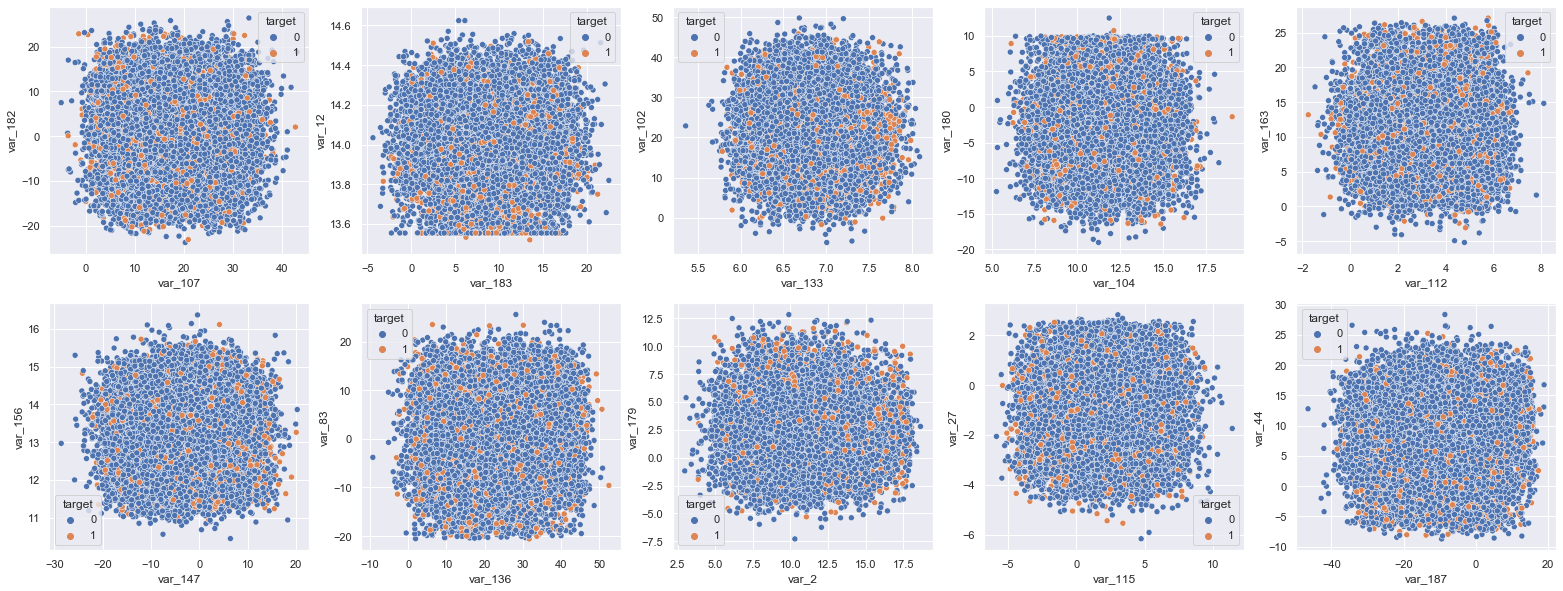

In [7]:
scatter_plot_test(data = train)

In [8]:
def scaler(dataset):
    df  = dataset.iloc[:,2:]
    scaler = StandardScaler()
    scaler.fit(df)

    dataset_scaled = scaler.transform(df)
    dataset_scaled = pd.DataFrame(dataset_scaled, columns = df.columns)
    df_result = pd.concat([dataset.iloc[:,0:2],dataset_scaled], axis = 1)
    return df_result, scaler

In [9]:
train_scaled, scaler_train = scaler(train)

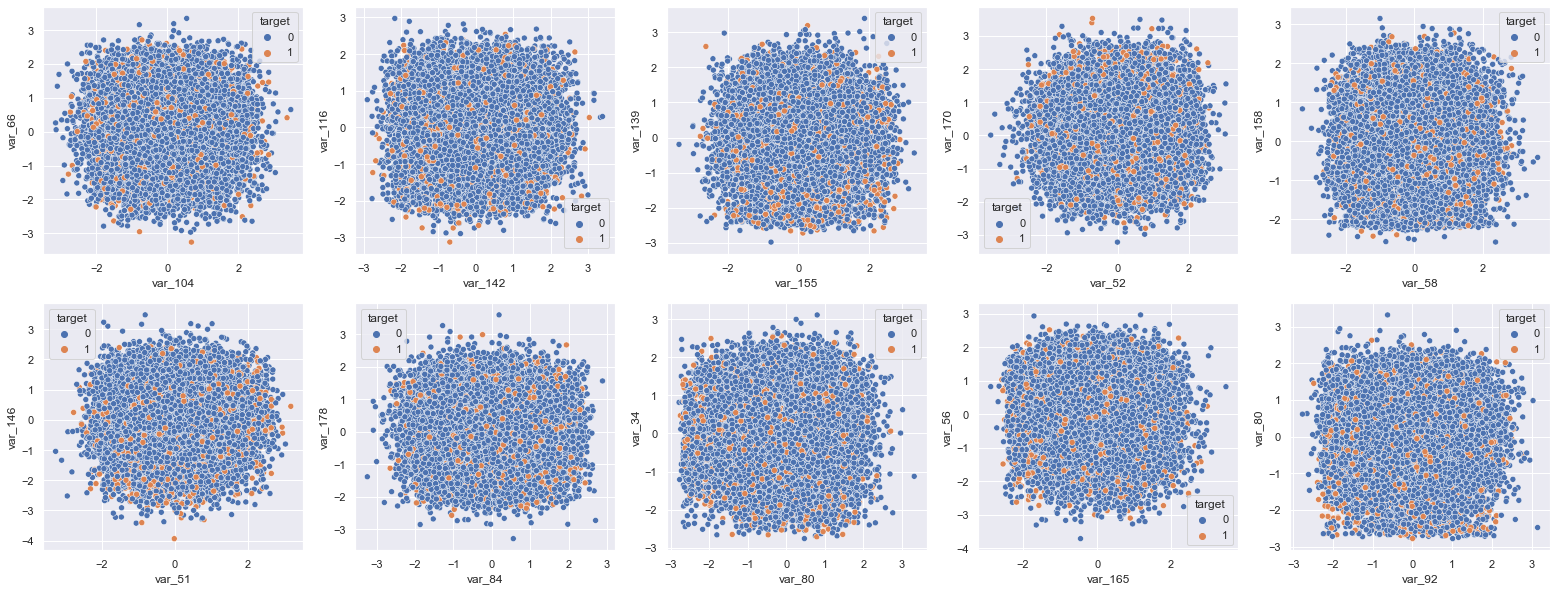

In [11]:
scatter_plot_test(data = train_scaled)

In [12]:
def threeD_plot(dataset,variables,fraq = 0.10):
    variables = variables + ["target"]
    fig = plt.figure(figsize=(13,13))
    df  = dataset.sample(frac = fraq, replace = False)
    ax = Axes3D(fig)
    categories = list(df["target"].unique())
    categories.sort()
    for category in categories:
        df_plot = df[df["target"] == category]
        countx = len(df_plot)
        alpha = 0.7
        if category != 1:
            alpha = 0.4
        sc = ax.scatter(df_plot[variables[0]], df_plot[variables[1]], df_plot[variables[2]], marker='o', alpha=alpha, label= f'{category}-{countx}' )
        
    ax.legend()
    ax.set_xlabel(variables[0])
    ax.set_ylabel(variables[0])
    ax.set_zlabel(variables[0])
    ax.set_facecolor("grey")
    plt.show()

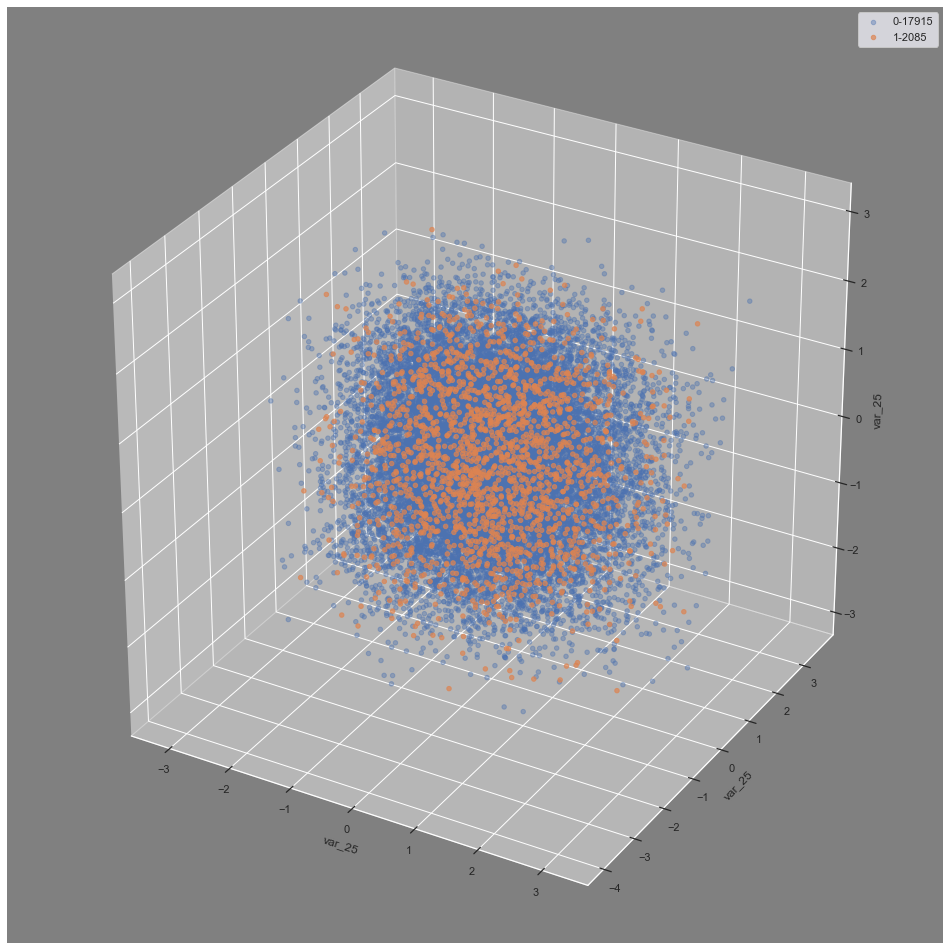

In [13]:
threeD_plot(train_scaled,['var_25', 'var_17', 'var_113'])

### Testing mahalanobis distance for espherical check

In [14]:
def mahalanobis(x=None, data=None,cov_mu = [False,False], cov=None, mu = None):
    if cov_mu[0] == False:
        cov = np.cov(data.values.T)
    elif cov_mu[0] == True:
        cov = cov
        
    if cov_mu[1] == False:
        x_mu = x - np.mean(data)
    elif cov_mu[1] == True:
        x_mu = x - mu

        
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

In [15]:
df = train_scaled[['var_25', 'var_17', 'var_113',"target"]].sample(frac = 0.10, replace = False).copy()
df['mahalanobis'] = mahalanobis(x=df[['var_25', 'var_17', 'var_113']], data=df[['var_25', 'var_17', 'var_113']])

In [16]:
def threeD_plot_mahalanobis(dataset,variables):
    variables = variables + ["target"]
    fig = plt.figure(figsize=(13,13))
    ax = Axes3D(fig) 
   
    ax.scatter(dataset[variables[0]], dataset[variables[1]], dataset[variables[2]], c = dataset['mahalanobis'], marker='o')

    ax.set_xlabel(variables[0])
    ax.set_ylabel(variables[0])
    ax.set_zlabel(variables[0])
    ax.set_facecolor("grey")
    plt.show()

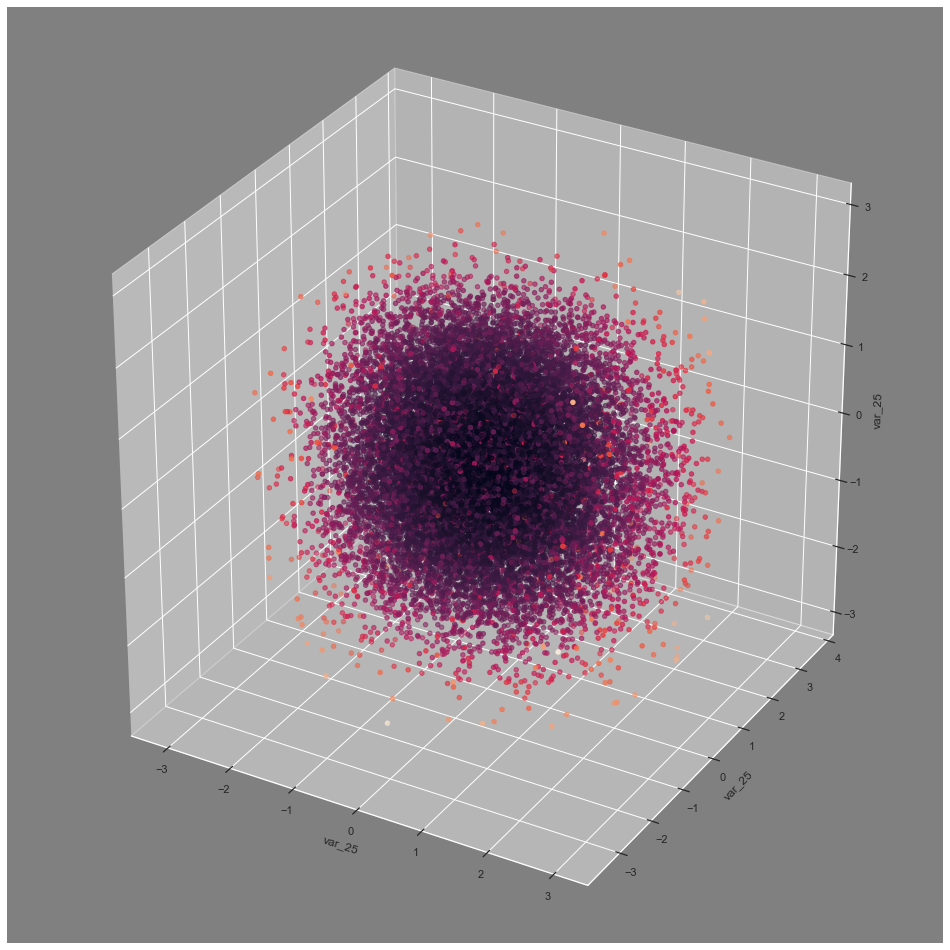

In [17]:
threeD_plot_mahalanobis(df,['var_25', 'var_17', 'var_113'])

In [18]:
def mahalanobis_vector_plot(data):
    df = data.copy()
    df = df.sort_values('mahalanobis').reset_index(drop = True)
    fig = plt.figure(figsize=(10,7))
    plt.scatter(df.index, df['mahalanobis'],marker='o')
    plt.xlabel('order')
    plt.ylabel('Mahalanobis distance')
    fig.show()

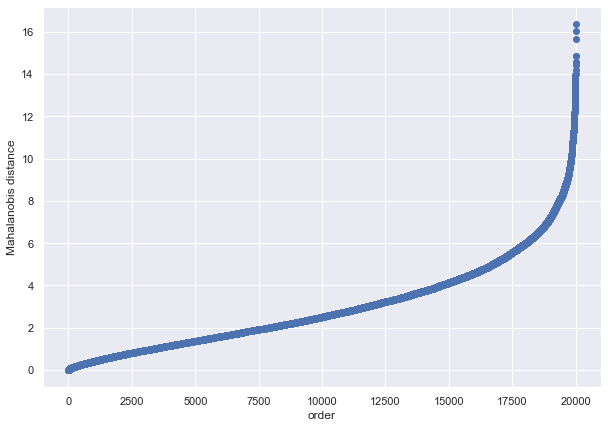

In [19]:
mahalanobis_vector_plot(df)

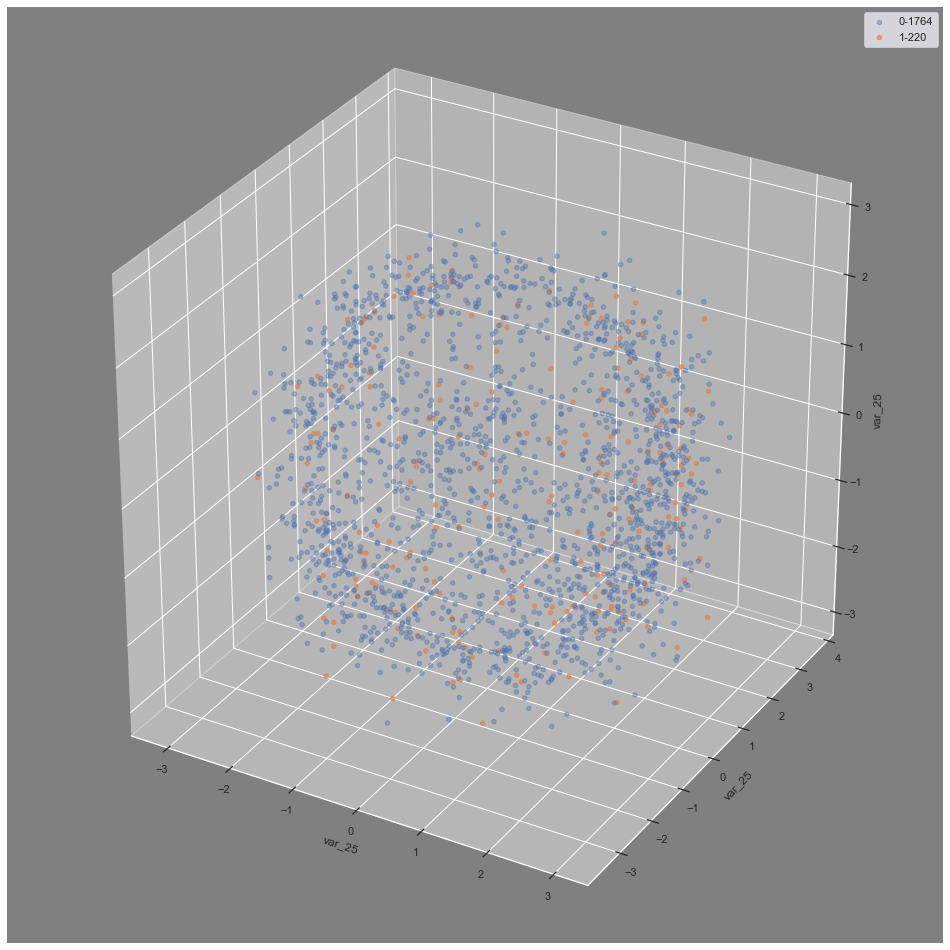

In [20]:
threeD_plot(df[(df['mahalanobis'] > 6)],['var_25', 'var_17', 'var_113'], fraq = 1.00)

### Insights

Data:
* no clear trend

thanks to MD, Augmentation strategy
* in concentrated places
* in empty places where low concentration of blus

### Feature Selection

In [91]:
seed = 158
validation_dataset = train.sample(frac = 0.25, replace = False, random_state = seed).reset_index(drop = True)
validation_dataset = validation_dataset.copy()
train_dataset = train[~train.index.isin(validation_dataset.index)].reset_index(drop = True)

In [92]:
train_dataset_scaled, _ = scaler(train_dataset)

In [93]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

train_dataset_scaled.iloc[:,2:].describe()

var_0       var_1       var_2       var_3       var_4       var_5  \
count 150000.0000 150000.0000 150000.0000 150000.0000 150000.0000 150000.0000   
mean       0.0000     -0.0000     -0.0000      0.0000      0.0000      0.0000   
std        1.0000      1.0000      1.0000      1.0000      1.0000      1.0000   
min       -3.3858     -3.3159     -3.2542     -3.3212     -3.7010     -3.4967   
25%       -0.7321     -0.7672     -0.7552     -0.7537     -0.7358     -0.7804   
50%       -0.0509      0.0047     -0.0492      0.0136      0.0193      0.0287   
75%        0.6836      0.7373      0.6820      0.7463      0.7273      0.7622   
max        3.1741      2.9632      3.2650      3.1283      3.0880      2.7976   

            var_6       var_7       var_8       var_9  ...     var_190  \
count 150000.0000 150000.0000 150000.0000 150000.0000  ... 150000.0000   
mean      -0.0000      0.0000      0.0000      0.0000  ...      0.0000   
std        1.0000      1.0000      1.0000      1.0000  ...      1.0000   
min       -3.5332     -3.2731     -3.2365     -2.9141  ...     -3.8026   
25%       -0.7402     -0.7609     -0.7820     -0.7687  ...     -0.7210   
50%       -0.0275     -0.0271      0.0369      0.0509  ...     -0.0087   
75%        0.6857      0.7498      0.7957      0.8238  ...      0.6944   
max        3.5063      3.2605      2.9582      2.9017  ...      3.3345   

          var_191     var_192     var_193     var_194     var_195     var_196  \
count 150000.0000 150000.0000 150000.0000 150000.0000 150000.0000 150000.0000   
mean       0.0000      0.0000     -0.0000      0.0000     -0.0000     -0.0000   
std        1.0000      1.0000      1.0000      1.0000      1.0000      1.0000   
min       -3.3509     -3.8788     -3.5493     -2.8969     -3.5819     -3.0257   
25%       -0.7535     -0.7042     -0.6890     -0.7536     -0.7203     -0.7793   
50%       -0.0306     -0.0181      0.0174     -0.0114     -0.0208      0.0195   
75%        0.6850      0.6906      0.7210      0.7653      0.6803      0.7807   
max        3.0700      4.3731      3.7414      3.1722      3.0857      2.8197   

          var_197     var_198     var_199  
count 150000.0000 150000.0000 150000.0000  
mean       0.0000      0.0000     -0.0000  
std        1.0000      1.0000      1.0000  
min       -3.0223     -3.1766     -3.4020  
25%       -0.7125     -0.6790     -0.7539  
50%       -0.0211      0.0218      0.0475  
75%        0.7432      0.7276      0.7825  
max        3.3012      3.3886      3.0474  

[8 rows x 200 columns]

no possible to apply the variance threshold

Arbitrary selection

In [31]:
numerical_features = ['var_4', 'var_12', 'var_46', 'var_78', 'var_81', 'var_110', 'var_152', 'var_175', 'var_183', 'var_199']

### Augmentation Techniques

In [32]:
def compute_mahalanobis_parts(data,numerical_features, chunk_size, cov_mu, mu, cov):
    
    chunks = list()
    num_chunks = len(data) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(data[i*chunk_size:(i+1)*chunk_size])
    
    treated_dfs = list()
    for chunk in chunks:
        chunk['mahalanobis'] = mahalanobis( x=chunk[numerical_features], data=chunk[numerical_features], cov_mu = cov_mu, mu = mu, cov = cov)
        treated_dfs.append(chunk)
    result_df = pd.concat(treated_dfs)
    #return chunks
    return result_df

In [33]:
train_dataset_scaled = train_dataset_scaled[ ['target'] + numerical_features]

means_train = np.mean(train_dataset_scaled[numerical_features])  ### Save this
cov_train = np.cov(train_dataset_scaled[numerical_features].T) ### Save this

In [97]:
train_dataset_scaled = compute_mahalanobis_parts(train_dataset_scaled, numerical_features, 30000,[True,True], means_train, cov_train )

In [99]:
train_dataset_scaled

target   var_4  var_12  var_46  var_78  var_81  var_110  var_152  \
0            0  1.4192  0.0924  1.5465  0.8931 -1.5595  -1.6769  -0.8946   
1            0  0.8208  0.5447 -2.2566  1.4854 -0.0465  -0.9087   0.5436   
2            0 -0.0357 -2.0171 -0.2909 -1.5701  0.2547   1.5986   0.3921   
3            0  1.7800  1.7795  1.1619  1.8091  0.8383  -1.5366  -1.1801   
4            0  0.1409  0.4178 -0.1324  0.5093  0.1469  -0.4865   0.1413   
...        ...     ...     ...     ...     ...     ...      ...      ...   
149995       0 -0.4543 -0.1999 -0.8876 -0.6575  0.7289  -1.6122   0.1106   
149996       0 -1.7065  2.0491  1.1438 -0.5746  1.4286   2.0440  -1.0518   
149997       0 -1.0705 -0.7712 -1.3579  1.1275  0.9694  -0.5341  -0.6449   
149998       0  0.8879  0.9849  0.5120  0.0938  2.9268  -0.6836  -2.6724   
149999       0  0.2963  1.1829 -0.2800 -1.4572  0.0207   0.3122   0.2914   

        var_175  var_183  var_199  mahalanobis  
0        0.8180   0.5149  -1.6809      14.9712  
1        0.5429  -0.9835   0.4622      10.8874  
2        0.6165   0.7902   1.1397      11.7172  
3       -1.4570  -1.0328   0.9935      19.5107  
4        0.9963   0.6817  -1.7067       5.1054  
...         ...      ...      ...          ...  
149995  -1.3611   0.1526  -1.3924       8.3939  
149996   0.0727   0.1467   0.3507      16.2724  
149997   0.3219   1.3857   0.7204       9.0894  
149998   0.0063   1.7057  -1.0127      22.1354  
149999   0.0427   0.7038   0.3316       4.4641  

[150000 rows x 12 columns]

In [101]:
gatito
train_dataset_scaled.to_csv('train_treated.csv')

In [34]:
train_dataset_scaled = pd.read_csv('train_treated.csv').drop(columns = ['Unnamed: 0'])

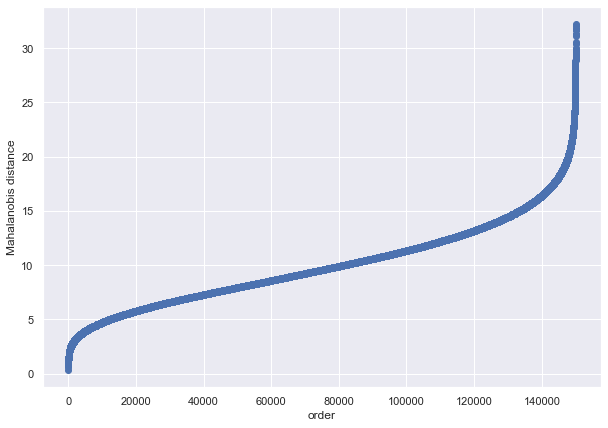

In [35]:
mahalanobis_vector_plot(train_dataset_scaled)

3 sections of train or input data using the mahalanobis distance

In [36]:
train_section_1 = train_dataset_scaled[train_dataset_scaled.mahalanobis > 15]
train_section_2 = train_dataset_scaled[(train_dataset_scaled.mahalanobis > 9) & (train_dataset_scaled.mahalanobis <= 15)]
train_section_3 = train_dataset_scaled[train_dataset_scaled.mahalanobis <= 9]

In [74]:
def normal_augmentation(data, columns, n, pop_mean, pop_cov ,range_distance = [None,None], label_target = 2, rate = 0):
    calc = 0
    var_limits = dict()
    for var in columns:
        var_limits[var] = {'mu': np.mean(data[var]),'std': np.std(data[var])}
    new_data = list()
    while calc < n:
        data_dict = dict()
        data_dict['target'] = label_target
        for var in columns:
            mu, std = var_limits[var]['mu'], var_limits[var]['std'], 
            value = np.random.normal(mu, std*(1 + rate), 1)[0]
            data_dict[var] = value
        data = pd.DataFrame(data_dict,index = [calc])
        data['mahalanobis'] = mahalanobis( x=data[columns], data=data[columns], cov_mu = [True,True], mu = pop_mean, cov = pop_cov)
        if data['mahalanobis'].values > range_distance[0] and data['mahalanobis'].values < range_distance[1]:
            new_data.append(data)
            calc = calc + 1
    new_data = pd.concat(new_data)
    return new_data

In [73]:
def concentrated_augmentation(data, columns, n, category, label_target = 3, rate = 0.015):
    data_selection = data[data.target == category]
    lenght = len(data_selection)
    new_data_result = list()
    for i in range(n):
        new_data_dict = dict()
        new_data_dict['target'] = label_target
        index = np.random.randint(low = 0, high=lenght, size=1)[0]
        data_dict = data_selection.iloc[index,:].copy().to_dict()
        for var in columns:
            q75, q25 = np.percentile(data_selection[var], [75 ,25])
            iqr = q75 - q25
            dist_param = iqr * rate
            dist = np.random.uniform(-dist_param,dist_param,1)[0]

            new_value = data_dict[var] + dist
            new_data_dict[var] = new_value
            #print(f'var{var} before {data_dict[var]} new:{new_data_dict[var]}')
        new_data_dict['mahalanobis'] = data_dict['mahalanobis']
        #print(data_dict,new_data_dict)
        new_data_df = pd.DataFrame(new_data_dict, index = [i])
        new_data_result.append(new_data_df)
    new_data_result = pd.concat(new_data_result)
    return new_data_result

In [60]:
train_section_1.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    13926
1     2650
Name: mahalanobis, dtype: int64

In [75]:
aug_normal = normal_augmentation(data = train_section_1 , columns = numerical_features, n = 1600,
                          pop_mean = means_train, pop_cov = cov_train,range_distance = [15,35], label_target = 2, rate = 0)

In [76]:
aug_normal2 = normal_augmentation(data = train_section_1 , columns = numerical_features, n = 1600,
                          pop_mean = means_train, pop_cov = cov_train,range_distance = [15,35], label_target = 6, rate = 0.5)

In [77]:
aug_conditioned_1 = concentrated_augmentation(data = train_section_1, columns = numerical_features, n = 1800, category = 1)

In [78]:
aug_conditioned_2 = concentrated_augmentation(data = aug_normal, columns = numerical_features, n = 800, category = 2, label_target = 4)

In [82]:
train_section_1_aug = pd.concat([train_section_1,aug_normal2])

In [83]:
train_section_1_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    13926
1     2650
6     1600
Name: mahalanobis, dtype: int64

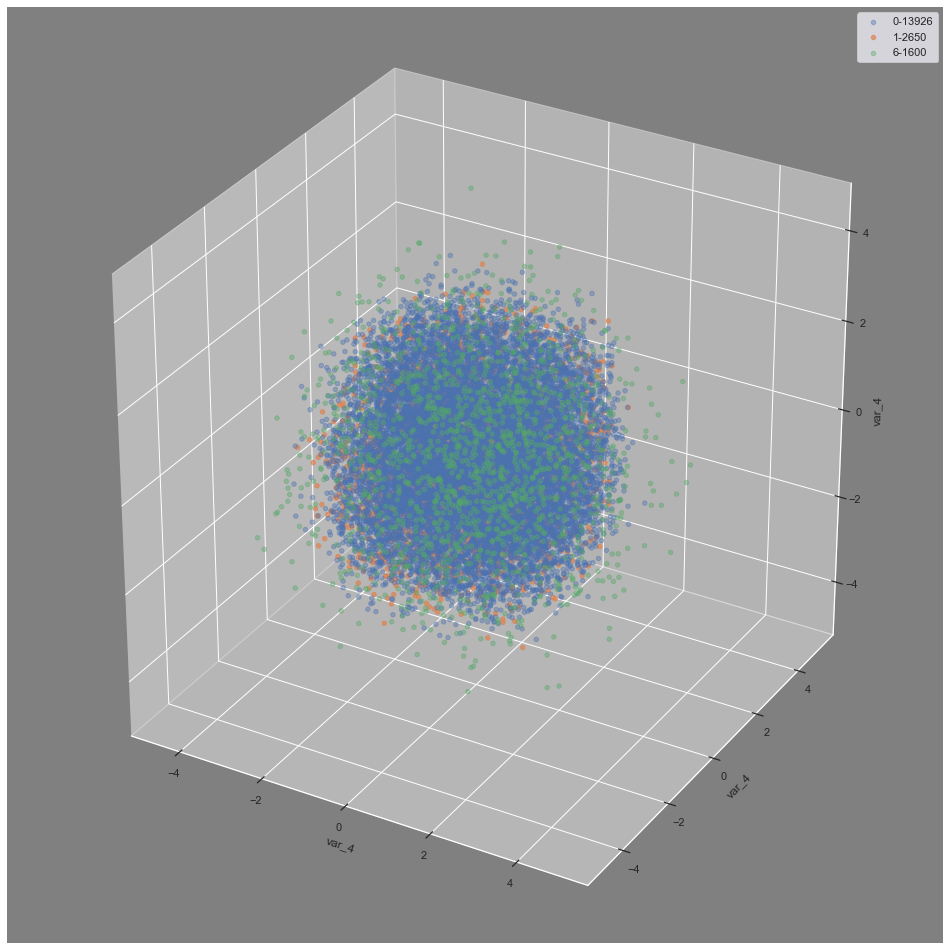

In [84]:
threeD_plot(train_section_1_aug,['var_4', 'var_12', 'var_46'], fraq = 1.0)

### General Conclusions

* Ten arbitrary features are taken given that no feature has a underlaying pattern (randomly and cloudly distributed)
* mahalanobis distance is used to get esperical partitiions of the data
* a new train csv with the mahalanobis distance is given
* functions of augmentations are given